# The Weird Detector curves

The bumps seen in the Kepler curves from [Wheeler and Kipping (2019)](https://ui.adsabs.harvard.edu/#abs/2019MNRAS.tmp..746W/abstract) could be forward scattering from hot Jupiters at high inclination that are not transiting their parent stars but are shedding a halo of gas or dust and we are seeing the forward scattering from them. This is a quick look at the data to see if thie is reasonable.

In [25]:
import numpy as np
from astropy import constants as c
from astropy import units as u
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [26]:
from astropy.table import Table
t = Table.read('woi_full.ecsv', format='ascii.ecsv')
t

KIC,Period,Amp,Amp_err,Tstar,Mstar,Rstar
,d,,,K,solMass,solRad
str12,float64,float64,float64,float64,float64,float64
KIC 6862114,27.68,0.62,0.03,7227.0,1.29,1.782
KIC 11397541,13.25,0.96,0.02,6254.0,1.08,1.064
KIC 7837214,7.49,0.99,0.04,6170.0,0.91,0.981
KIC 4371947,19.72,0.36,0.02,6720.0,1.44,1.671
KIC 8694536,35.95,0.28,0.01,6279.0,1.063,1.525
KIC 7870350,23.142,0.35,0.01,6444.0,1.22,1.436
KIC 10737327,22.78,0.22,0.02,6244.0,1.08,1.017
KIC 5363987,47.42,0.32,0.02,6190.0,0.97,1.196


Text(0, 0.5, 'Amplitude [ppt]')

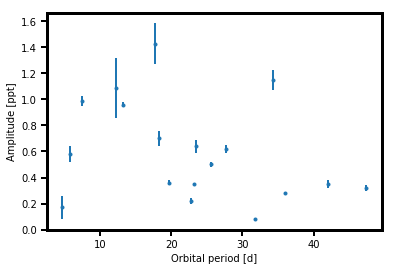

In [27]:
plt.errorbar(t['Period'],t['Amp'],yerr=t['Amp_err'],fmt='.')
plt.xlabel('Orbital period [d]')
plt.ylabel('Amplitude [ppt]')

In [28]:
@u.quantity_input
def vmaxellip(m1:u.Msun,m2:u.Mjup,P:u.year,e)->u.km/u.s:
    """
    Elliptical maximum velocity

    Args:
        m1: Primary and secondary masses
        P: orbital period
        e: eccentricity [0,1)

    Returns:
        velocity: maximum velocity in elliptical orbit

    >>> import astropy.units as u
    >>> vmaxellip(1.0 *u.M_sun, 1.0 * u.M_earth, 1.0 * u.yr, 0.0)
    <Quantity 29.78490916 km / s>
    """
    mu =  c.G * (m1 + m2)
    c1 = 2 * np.pi * mu / P
    c2 = (1 + e) / (1 - e)

    vmax = np.power(c1, 1./3.) * np.power(c2, 1./2.)
    # http://en.wikipedia.org/wiki/Circular_orbit
    return vmax

@u.quantity_input
def vcirc(m1:u.Msun,m2:u.Mjup,a:u.au)->u.km/u.s:
    """
    Circular orbital velocity of m2 about m1 at distance a

    Args:
        m1, m2: Primary and secondary masses
        a: semimajor axis

    Returns:
        velocity: circular orbital velocity

    >>> import astropy.units as u
    >>> vcirc(1.0 *u.M_sun, 1.0 * u.M_jup, 5.2 * u.au)
    <Quantity 13.06768412 km / s>
    """

    # http://en.wikipedia.org/wiki/Circular_orbit
    mu = c.G * (m1 + m2)
    vcirc = np.power(mu /a, 0.5)
    return vcirc


@u.quantity_input
def rhill(m1: u.Msun, m2: u.Mjup, a: u.au)->u.au:
    """
    Hill radius of the secondary m2 orbiting around m1
    
    Args:
        m1, m2: primary and secondary masses
        a: distance between m1 and m2

    Returns:
        rhill: radius of Hill sphere of m2

    >>> import astropy.units as u
    >>> rhill(1.0 * u.M_sun, 1.0 * u.M_jup, 5.2 * u.au)
    <Quantity 0.35489325 AU>
    """

    mu = m2 / (m1 + m2)
    rh = a * np.power(mu/3., 1./3.)
    return rh

@u.quantity_input
def Ptoa(P:u.year, m1:u.M_sun, m2:u.M_jup)->u.au:
    """calculate orbital radius from period

    Args:
        P: orbital period
        m1, m2: Primary and secondary masses

    Returns:
        a: semi-major axis

    >>> import astropy.units as u
    >>> Ptoa(11.86*u.year, 1.0*u.M_sun, 1.0*u.M_jup)
    <Quantity 5.20222482 AU>
    """

    # a^3/P^2 = (G/4pipi) (m1 + m2)
    const = c.G / (4.*np.pi*np.pi)
    mu = m1 + m2
    a3 = (P*P*const*mu).decompose()
    aa = np.power(a3, 1./3.)
    
    return aa

@u.quantity_input
def Teq(T:u.K, R:u.R_sun, a_orb:u.au, alb)->u.K:
    """calculate equilibrium temperature from a star

    Args:
        T: temperature of the star
        R: radius of the star
        a_orb: orbital distance of the planet
        alb: albedo of the planet

    Returns:
        Teq: temperature of the planet

    >>> import astropy.units as u
    >>> Ptoa(11.86*u.year, 1.0*u.M_sun, 1.0*u.M_jup)
    <Quantity 5.20222482 AU>
    """

    # teq = T(1-a)^1/4 sqrt (r/2D)
    a1 = T * np.power(1-alb, 0.25)
    a2 = np.sqrt(R/(2*a_orb))
    return a1*a2


In [29]:
a_planet = Ptoa(t['Period'].to(u.year), t['Mstar'], np.zeros_like(t['Mstar'])).to(u.au)

Text(0, 0.5, 'Amplitude [ppt]')

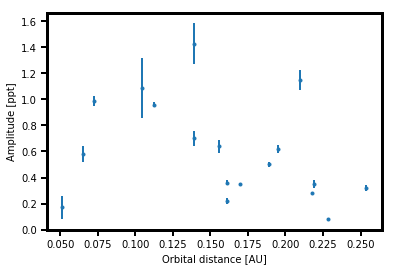

In [30]:
plt.errorbar(a_planet.value,t['Amp'],yerr=t['Amp_err'],fmt='.')
plt.xlabel('Orbital distance [AU]')
plt.ylabel('Amplitude [ppt]')

In [31]:
Tplanet = Teq(t['Tstar'], t['Rstar'], a_planet, 0.0)
print(Tplanet)

[1053.63704356  927.72418623 1093.66656822 1042.94375011  801.62207708
  903.59105629  755.90568542  647.94758182  499.22206435  654.78463138
 1411.90879775  849.69942478  933.2712101   826.31888443  867.39764935
 1021.93461675 1501.631615   1075.64530438] K


Text(0, 0.5, 'Amplitude [ppt]')

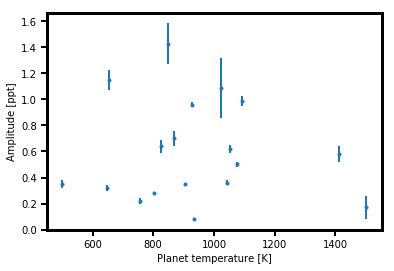

In [32]:
plt.errorbar(Tplanet.value,t['Amp'],yerr=t['Amp_err'],fmt='.')
plt.xlabel('Planet temperature [K]')
plt.ylabel('Amplitude [ppt]')

So, there's little correlation with planet temperature and amplitude of the effect, but at least the planets are all hot enough to have evaporation off and form an exosphere. The variation could be due to inclination angle and mass of the exoplanet, plenty of room there.
